In [1]:
!pip install tpot

In [0]:
from itertools import chain
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier

import xgboost
from tpot import TPOTClassifier

dataset = pd.read_csv('/content/drive/My Drive/Datastorm/credit_card_default_train.csv')

X = dataset.drop(['Client_ID','NEXT_MONTH_DEFAULT'],axis=1)
Y = dataset['NEXT_MONTH_DEFAULT']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)


**Grouping categorical features and numerical features**

In [0]:
X_cat_columns = []
X_num_columns = []
#Grouping categorical features other than clientID
for i in range(len(X.columns)):
    if X.dtypes[i] == object:
        X_cat_columns.append(X.columns[i])
    else:
        X_num_columns.append(X.columns[i])



**Transforming data**

In [0]:
ohe = OneHotEncoder(sparse=False)
scaler = StandardScaler()

transformer = ColumnTransformer([('categorical',ohe,X_cat_columns),('numerical',scaler,X_num_columns)])

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

**Visualization Functions**

In [0]:
def plot_accuracy(accuracies,min_max):
  figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
  min_comp,max_comp = min_max
  plt.plot([i for i in range(min_comp,max_comp)],accuracies)
  plt.xlabel('n_components')
  plt.xticks(np.arange(min_comp,max_comp+1,1))
  plt.ylabel('accuracy')
  plt.show()

**Prediction using XGBoost**

In [0]:
def XGBoost_predict(X_train,X_test,Y_train,Y_test): 

  #using XGBoost Classifier to predict
  xgb = xgboost.XGBClassifier()
  xgb.fit(X_train, Y_train)
  Y_pred = xgb.predict(X_test)

  return accuracy_score(Y_test, Y_pred)

In [7]:
print(XGBoost_predict(X_train_transformed,X_test_transformed,Y_train,Y_test))

0.8245833333333333


**Upsampling data using SMOTE**

In [8]:
!pip install imblearn

In [9]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_upsampled, Y_train_upsampled = smt.fit_sample(X_train_transformed, Y_train)

smt1 = SMOTE()
X_test_upsampled, Y_test_upsampled = smt.fit_sample(X_test_transformed, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

**Prediction with upsampled data**

In [10]:
model = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3,
                                        min_samples_split=18,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best')

model.fit(X_train_upsampled,Y_train_upsampled)
Y_pred = model.predict(X_test_upsampled)
accuracy_score(Y_test_upsampled,Y_pred)

0.7060189319521343

In [11]:
print(XGBoost_predict(X_train_upsampled,X_test_transformed, Y_train_upsampled,Y_test))

0.80875


**PCA on data**

In [0]:
def PCA_on_data(X_train,X_test,Y_train,Y_test,n_comp):

  #performing PCA on given data
  pca = PCA(n_components=n_comp)
  X_train_reduced = pca.fit_transform(X_train)
  X_test_reduced = pca.transform(X_test)

  return (X_train_reduced,X_test_reduced,Y_train,Y_test)

**Prediction on data with PCA**

maximum accuracy is:  0.8193055555555555  with  22  components


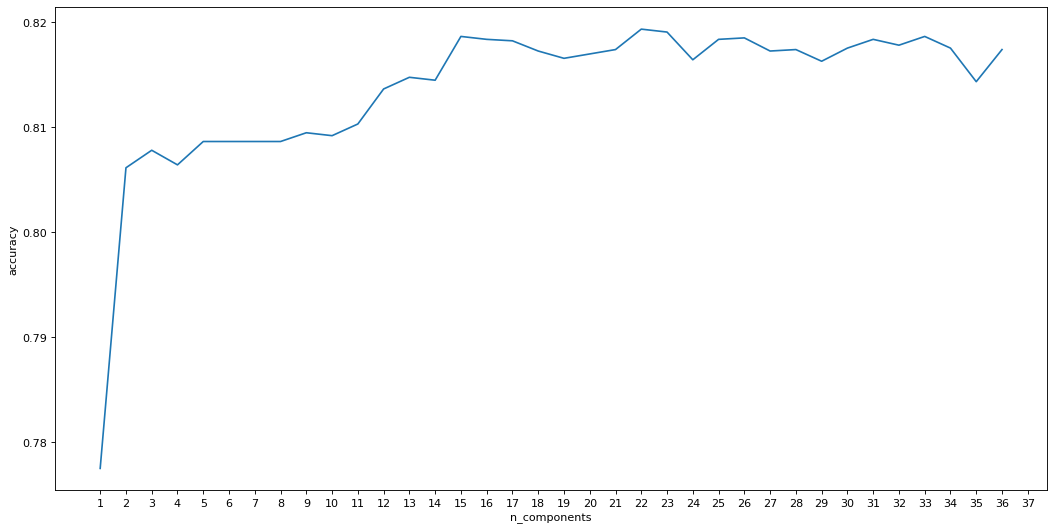

In [13]:
PCA_accuracy = []

for n_comp in range(1,X_train_transformed.shape[1]):
  PCA_accuracy.append(XGBoost_predict(*PCA_on_data(X_train_transformed,X_test_transformed,Y_train,Y_test,n_comp)))

max_accuracy = max(PCA_accuracy)

print("maximum accuracy is: ", max_accuracy, " with ", PCA_accuracy.index(max_accuracy)+1 ," components")

plot_accuracy(PCA_accuracy,[1,X_train_transformed.shape[1]])

**Prediction on upsampled data with PCA**

maximum accuracy is:  0.78  with  12  components


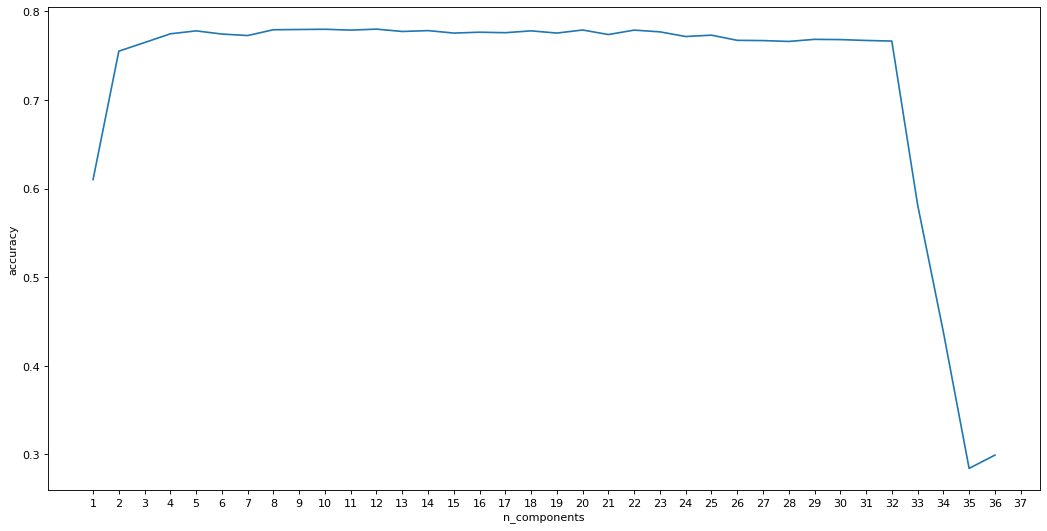

In [14]:
PCA_upsampled_accuracy = []

for n_comp in range(1,X_train_upsampled.shape[1]):
  PCA_upsampled_accuracy.append(XGBoost_predict(*PCA_on_data(X_train_upsampled,X_test_transformed,Y_train_upsampled,Y_test,n_comp)))

print("maximum accuracy is: ", max(PCA_upsampled_accuracy), " with ", PCA_upsampled_accuracy.index(max(PCA_upsampled_accuracy))+1 ," components")

plot_accuracy(PCA_upsampled_accuracy,[1,X_train_upsampled.shape[1]])

**(Optional) TPOT Method**

In [0]:
classifier = TPOTClassifier(generations=100, population_size=100,
                          offspring_size=None, mutation_rate=0.9,
                          crossover_rate=0.1,
                          scoring='accuracy', cv=5,
                          subsample=1.0, n_jobs=-1,
                          max_time_mins=30, max_eval_time_mins=5,
                          random_state=42,
                          verbosity=2)

classifier.fit(X_train_transformed,Y_train)
classifier.score(X_test,Y_test)